# Introduction to Implicit Time Integration - Conservation law

In [1]:
# Basic modules and graphics settings
%matplotlib inline 
import numpy  
import math                     
from matplotlib import pyplot    
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

## Some basic explicit time integration

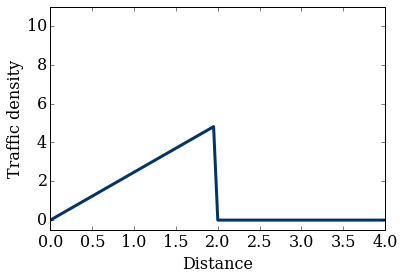

In [57]:
# Specifit modules
from ltrafflux import computeF      # Traffic flux

# Input parameters
nx = 81      # number of points in space
tt = 2.0     # total time of simulation
lx = 4.      # 1D domain length 
sigma = 1.   # sigma <= 1.0
rho_max   = 10.
u_max     = 1.
rho_light = 5. # to prevent negative wave speeds (which this ftbs scheme cannot handle)

# Discretization
dx = lx/(nx-1)                 # grid interval size in space
x  = numpy.linspace(0.,lx,nx)  # spatial grid
dt = sigma*dx/u_max  
nt = int(math.floor(tt/dt))    # Computes the numper of time steps required to reach tt

# Initial condition
def rho_green_light(nx, rho_max, rho_light):
    """Computes "green light" initial condition with shock, and linear distribution behind

    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_light : float
        Density of cars at stoplight

    Returns
    -------
    rho: array of floats
        Array with initial values of density
    """    
    rho = numpy.arange(nx)*(lx/2.)/nx*rho_light  # Before stoplight
    ubound = numpy.where(x >= (lx/2.))
    rho[ubound] = 0. 
    
    return rho

rho = rho_green_light(nx, rho_max, rho_light)

pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

In [58]:
def BFDResidual(dx, u):
    """Computes the residual of the 1-D nonlinear convection equation
    spatially discretized by backward finite differences.
    
    Computes -(u_i/dx)*(u_i-u_{i-1}) where

    Parameters
    ----------
    * dx : float
        [in] Spatial grid step
    * u  : array of floats
        [in] Array of state variables
		
    Returns
    -------    
    Res : array
        Array with the residual
    """
    F = computeF(u_max, rho_max, u)
    
    return (-1./dx)*(F[1:-1] - F[:-2])


def DuBFDResidual(dx, u):
    """Computes the Jacobian (residual derivative relative to state
    variables) of the 1-D linear convection equation spatially
    discretized by backward finite differences.
    
    Computes -(c/dx)*d_u(u_i-u_{i-1}) where

    Parameters
    ----------
    * dx : float
        [in] Spatial grid step
    * u  : array of floats
        [in] Array of state variables
		
    Returns
    -------    
    DR : matrix
        [out] Matrix with the derivative of residual in the state variables
    """
    DF = computeDF(u_max, rho_max, u)
    DR = numpy.zeros( (len(u), len(u)) )
    i  = numpy.arange( 1, len(u)-1 )
    DR[i, i] = DF[1:-1]
    DR[i[1:],i[:-1]] = -DF[1:-2]
    
    return (-1./dx)*DR

In [59]:
def explicitEuler(u, nt, dt, dx):

    # Inicializa os resultados com dimensoes nt X nx
    un = numpy.zeros( (nt,len(u)) )
    # Copia o u inicial em todas as linhas
    un[:,:] = u.copy()

    for t in range(1, nt):  
        Residual = BFDResidual(dx, u)
        un[t,1:-1] = u[1:-1] + dt*Residual # u_{n+1}
        un[t, 0] = u[ 0]    # C.C.
        un[t,-1] = u[-1]    # C.C
        u = un[t].copy()    # u_{n+1} -> u_n
        
    return un

un = explicitEuler(rho, nt, dt, dx)


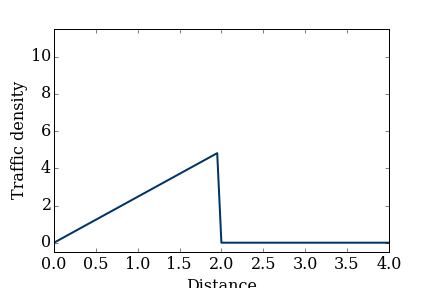
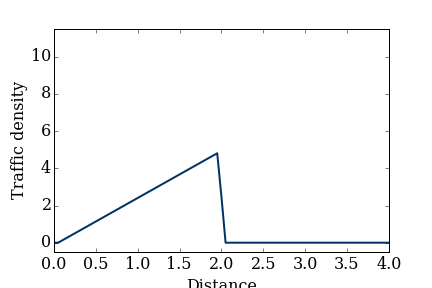
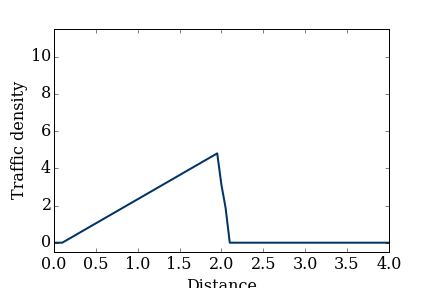
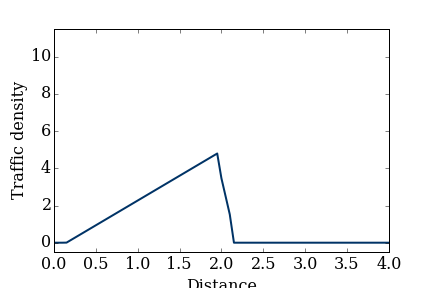
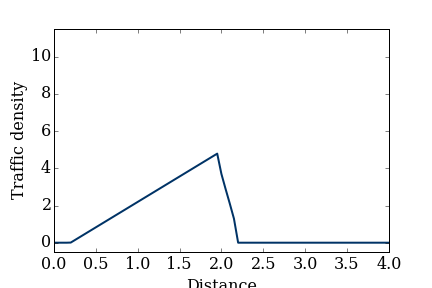
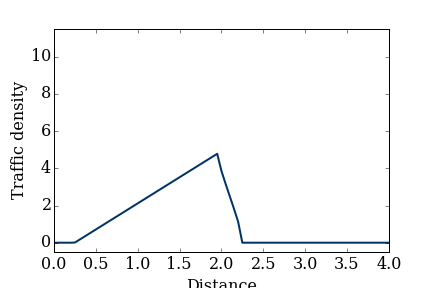
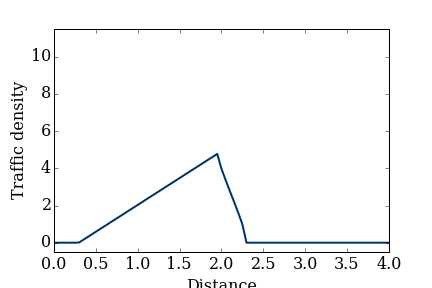
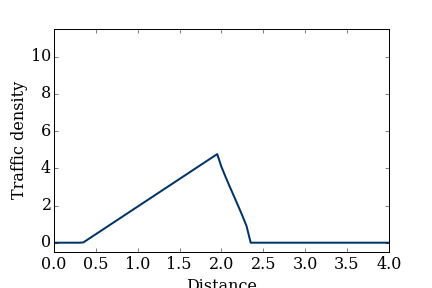
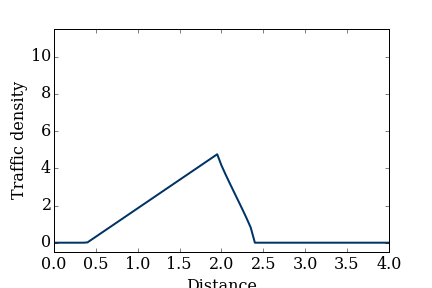
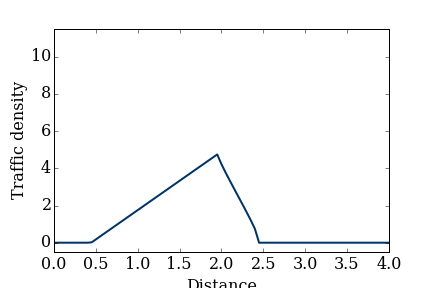
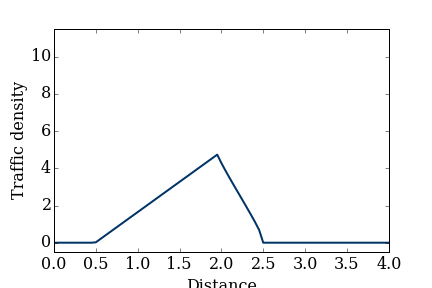
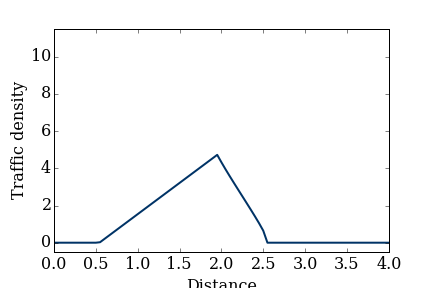
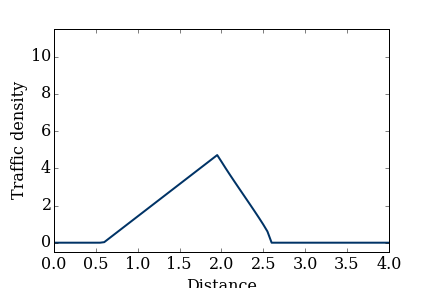
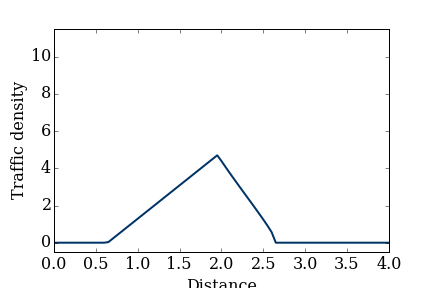
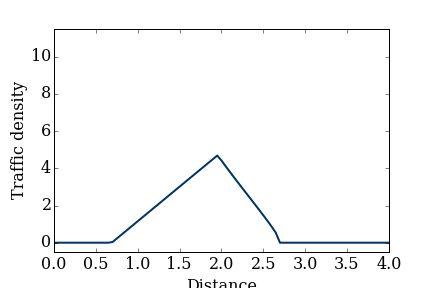
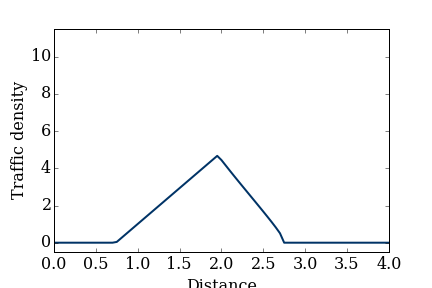
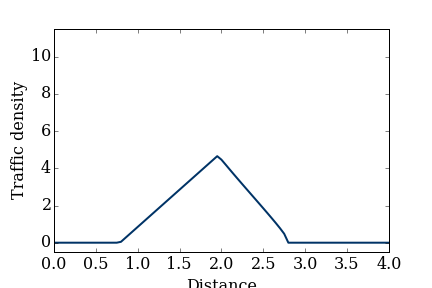
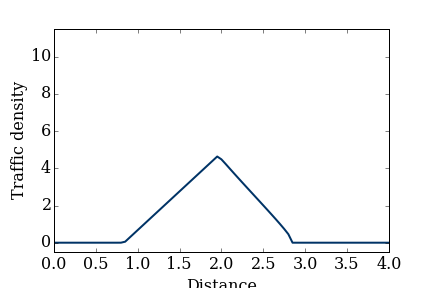
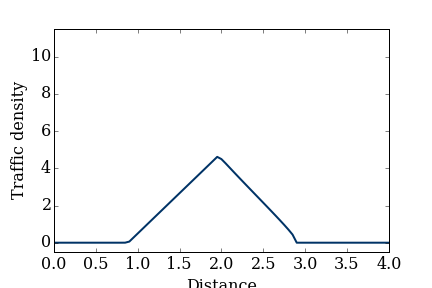
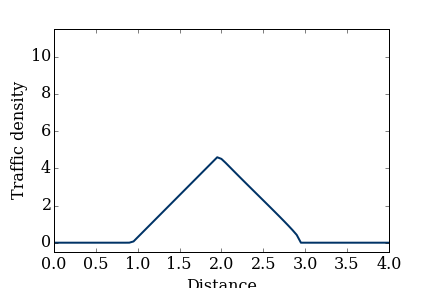
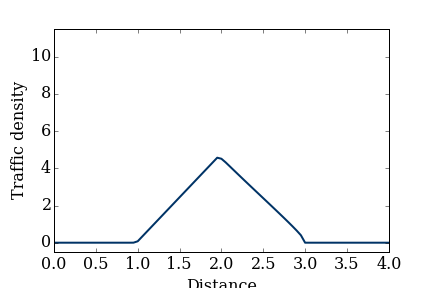
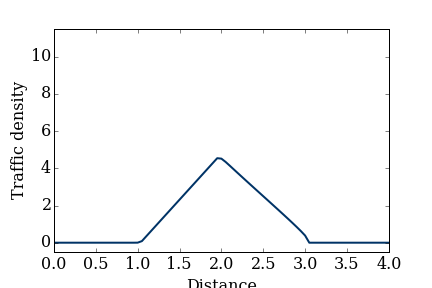
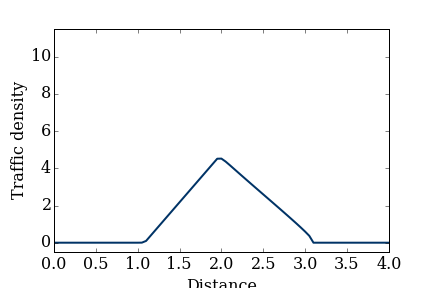
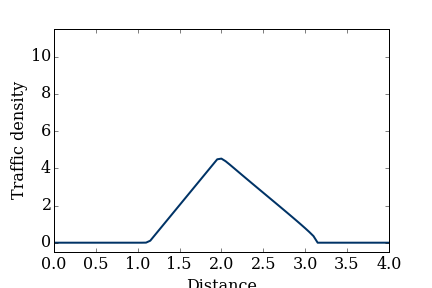
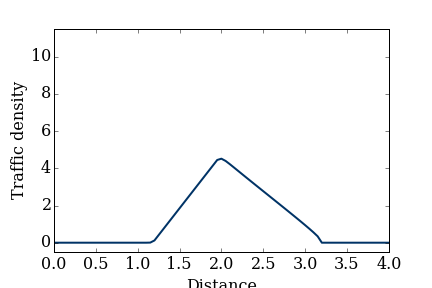
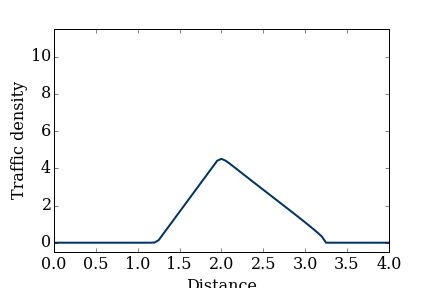
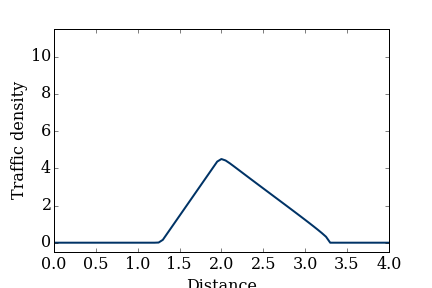
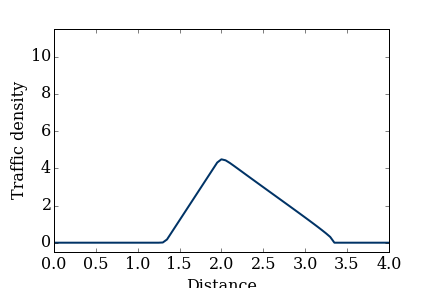
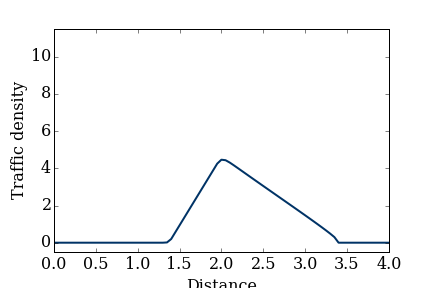
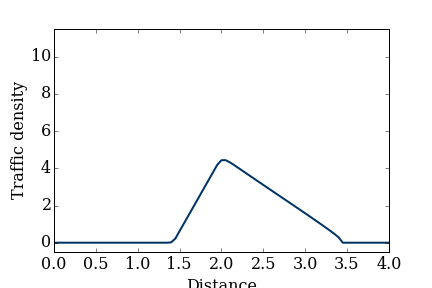
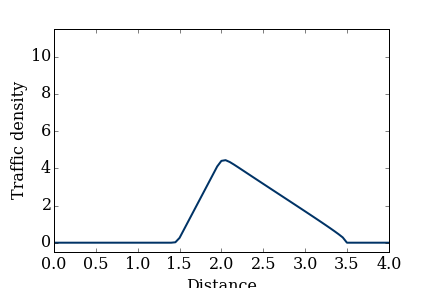
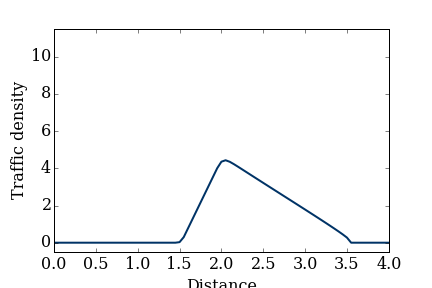
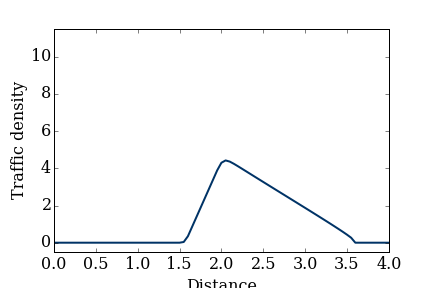
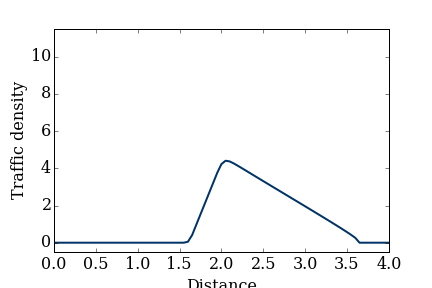
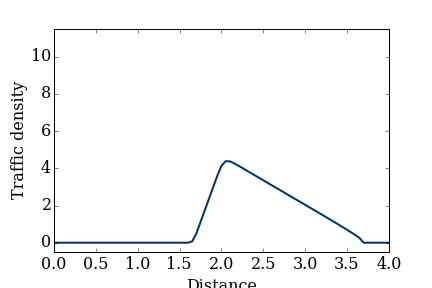
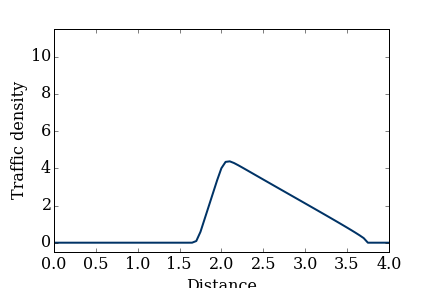
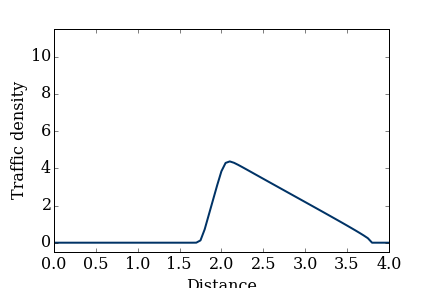
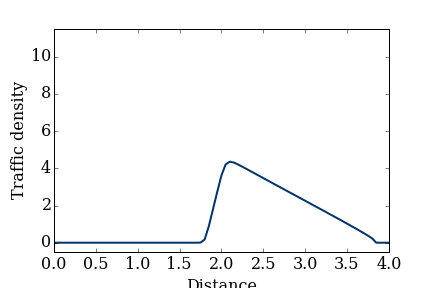
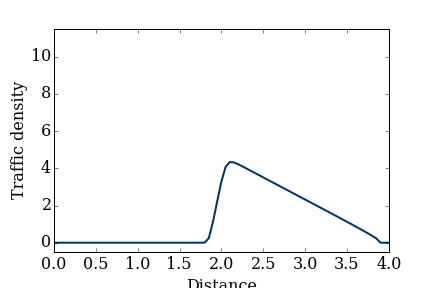
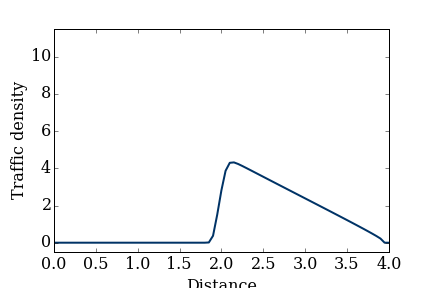

In [60]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,lx),ylim=(-.5,11.5),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(0,lx,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=un, interval=50)
display_animation(anim, default_mode='once')

## Backward Euler Implicit Time Integration

In [69]:
# Specifit modules
from ltrafflux import computeF      # Traffic flux
from ltrafflux import computeDF

# Input parameters
nx = 201      # number of points in space
tt = 2.       # total time of simulation
lx = 4.       # 1D domain length 
sigma = 3.   # sigma <= 1.0 for explicit time integration
rho_max   = 10.
u_max     = 1.
rho_light = 5. # to prevent negative wave speeds (which this ftbs scheme cannot handle)

# Discretization
dx = lx/(nx-1)                 # grid interval size in space
x  = numpy.linspace(0.,lx,nx)  # spatial grid
dt = sigma*dx/u_max  
nt = int(math.floor(tt/dt))    # Computes the numper of time steps required to reach tt

# Initial condition
rho = rho_green_light(nx, rho_max, rho_light)

In [70]:
def implicitEuler(u, nt, dt, dx):

    # Inicializa os resultados com dimensoes nt X nx
    un = numpy.zeros( (nt,len(u)) )
    # Copia o u inicial em todas as linhas
    un[:,:] = u.copy()
    # Delta_u
    du = numpy.zeros(len(u))

    for t in range(1, nt):  
        # Initial test
        Residual    = BFDResidual(dx, u) # Already [-1,1], check diffus.py
        Du_Residual = DuBFDResidual(dx, u)                
        A = (1./dt)*numpy.eye(len(u)) - Du_Residual
        b = Residual 
        du[1:-1] = numpy.linalg.solve( A[1:-1,1:-1],b ) 
        err = numpy.linalg.norm(du[1:-1])
        u = u + du # for the linearized fully implicit, we stop here
        
        k = 0
        maxit = 5
        epsilon = 1.e-5
                
        while (err > epsilon) and (k < maxit):
            k = k+1
            Residual    = BFDResidual(dx, u) # Already [-1,1], check diffus.py
            Du_Residual = DuBFDResidual(dx, u)                
            A = (1./dt)*numpy.eye(len(u)) - Du_Residual
            b = Residual - (1./dt)*(u[1:-1] - un[t-1,1:-1])
            du[1:-1] = numpy.linalg.solve( A[1:-1,1:-1],b )
            err = numpy.linalg.norm(du[1:-1])
            u = u + du
            
        print("Time step = ", t," -> Number of LSS = ", k+1, " -> ||du|| = ", err)
        
        un[t,1:] = u[1:]    # u_{n+1}
        un[t, 0] = u[ 0]    # C.C.
        un[t,-1] = u[-1]    # C.C
        
    return un

un = implicitEuler(rho, nt, dt, dx)

Time step =  1  -> Number of LSS =  5  -> ||du|| =  8.31172146923e-11
Time step =  2  -> Number of LSS =  4  -> ||du|| =  3.62902206366e-07
Time step =  3  -> Number of LSS =  4  -> ||du|| =  8.66012166818e-09
Time step =  4  -> Number of LSS =  4  -> ||du|| =  3.40071328014e-10
Time step =  5  -> Number of LSS =  4  -> ||du|| =  2.02712704393e-11
Time step =  6  -> Number of LSS =  3  -> ||du|| =  4.45528044818e-06
Time step =  7  -> Number of LSS =  3  -> ||du|| =  1.75995028618e-06
Time step =  8  -> Number of LSS =  3  -> ||du|| =  7.87330858447e-07
Time step =  9  -> Number of LSS =  3  -> ||du|| =  3.88450339194e-07
Time step =  10  -> Number of LSS =  3  -> ||du|| =  2.07646994081e-07
Time step =  11  -> Number of LSS =  3  -> ||du|| =  1.19191897564e-07
Time step =  12  -> Number of LSS =  3  -> ||du|| =  7.38014052432e-08
Time step =  13  -> Number of LSS =  3  -> ||du|| =  5.07109275791e-08
Time step =  14  -> Number of LSS =  3  -> ||du|| =  4.07252005012e-08
Time step =  15


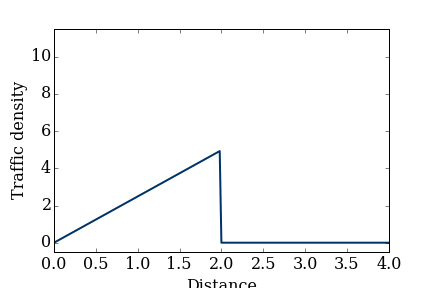
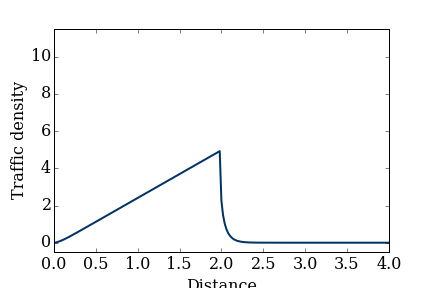
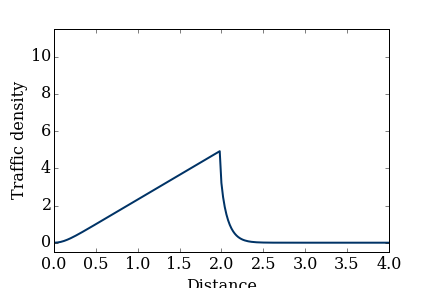
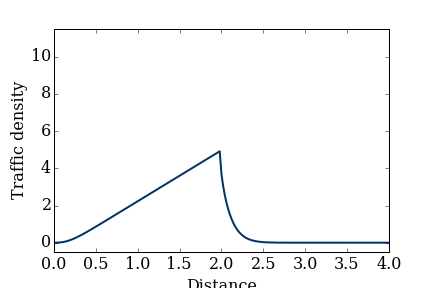
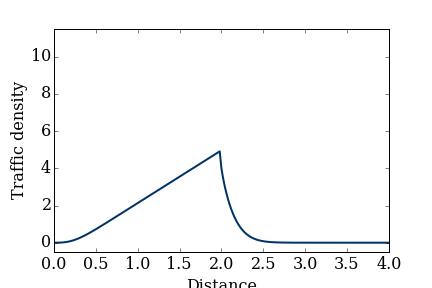
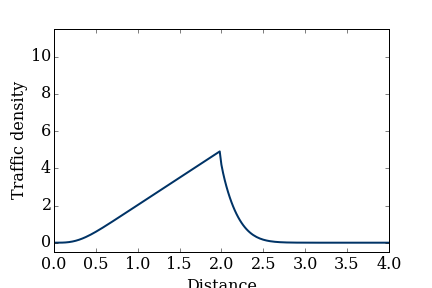
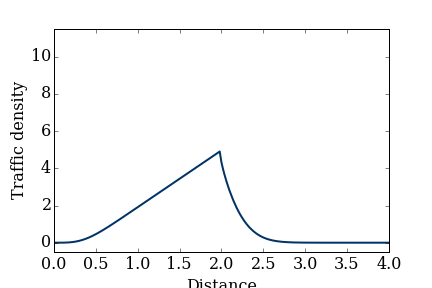
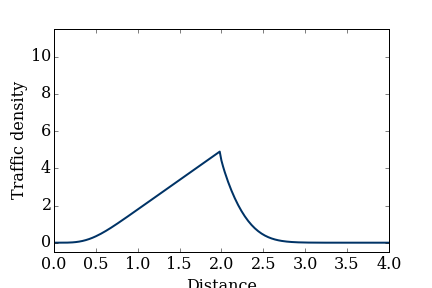
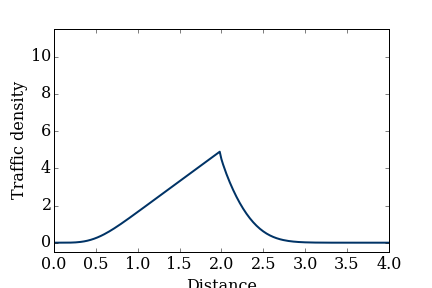
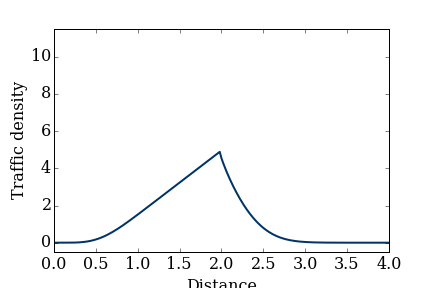
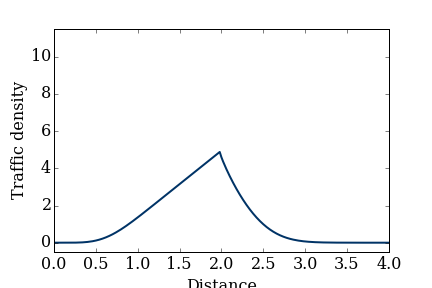
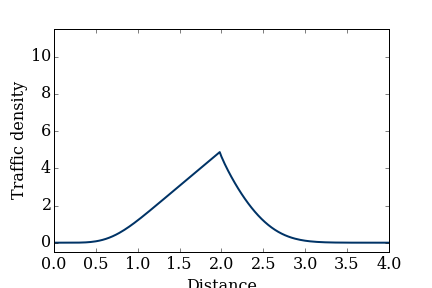
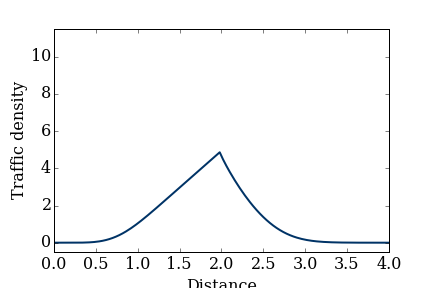
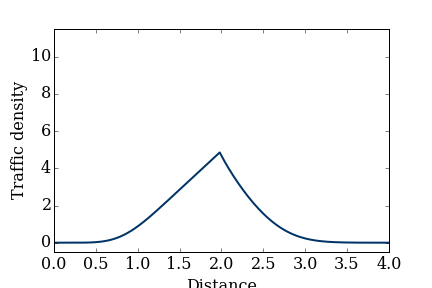
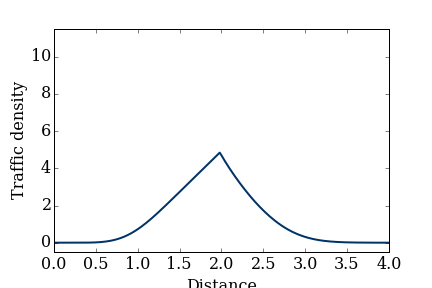
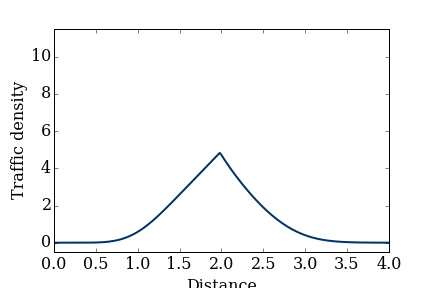
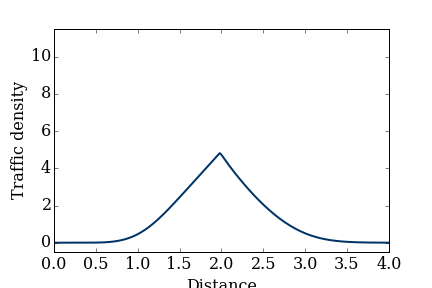
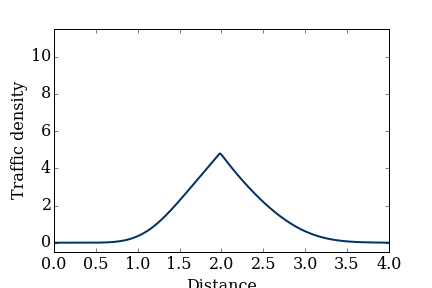
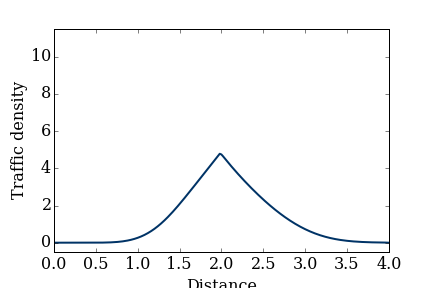
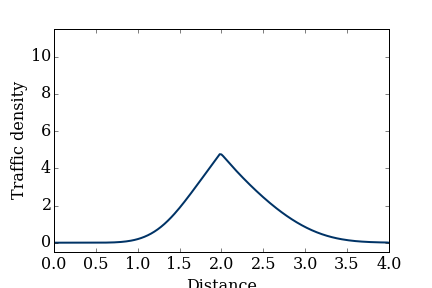
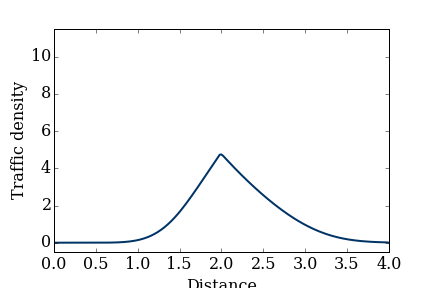
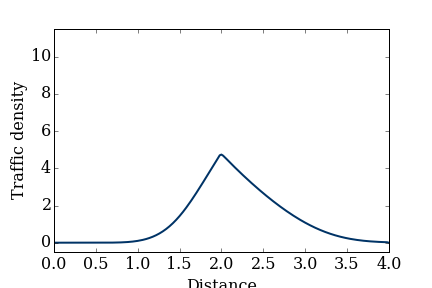
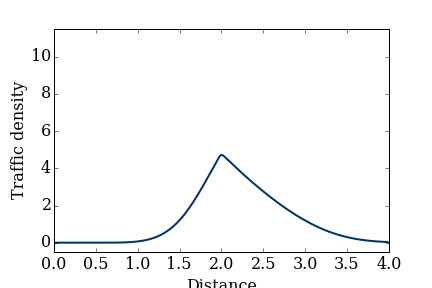
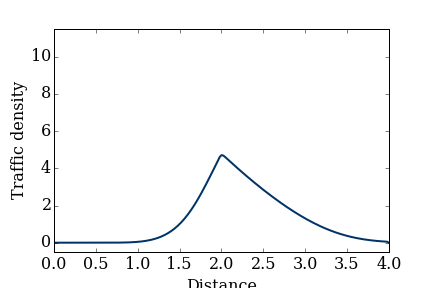
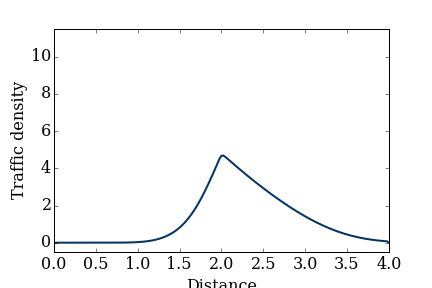
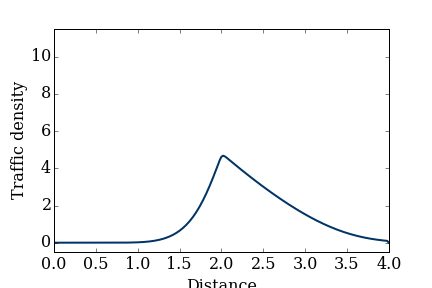
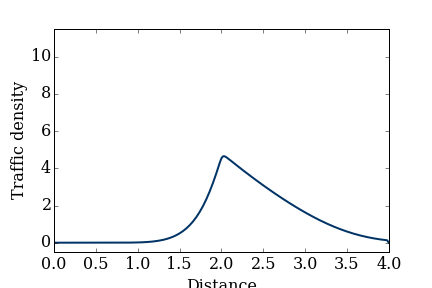
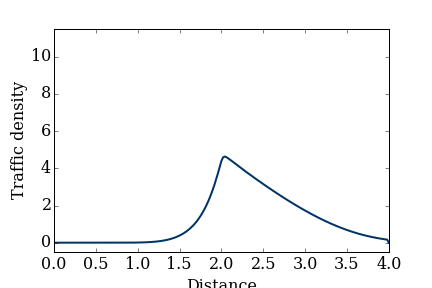
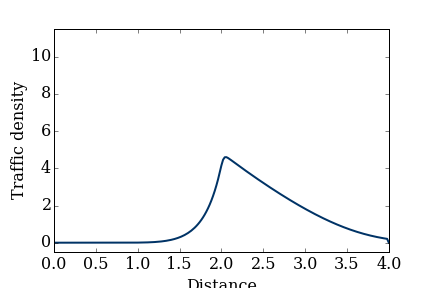
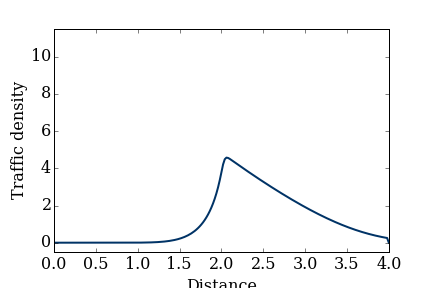
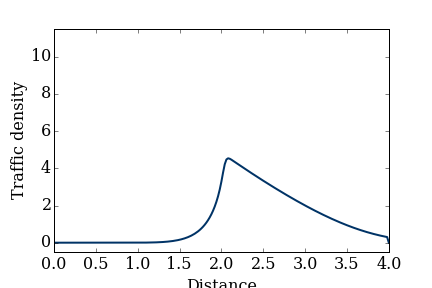
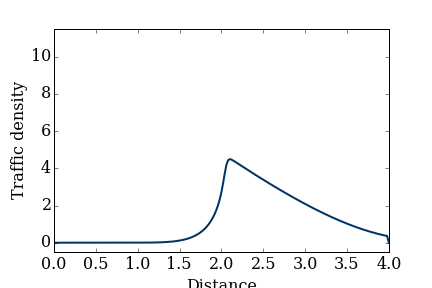
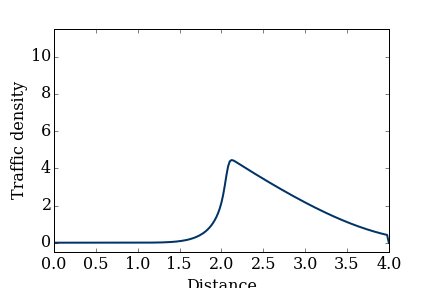

In [71]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,lx),ylim=(-.5,11.5),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=un, interval=50)
display_animation(anim, default_mode='once')